# The Policy Gradient Problem

In this notebook, we will step through calculations of policy gradients both analytically for linear quadratic systems, as well as with a few different algorithms. It won't take long however, to see that the standard policy gradient is *not* actually the best thing to compute. So, we will later discuss how to compute a variation of policy gradients, known as natural policy gradients. (See the paper by Peters, Vijayakumar, and Schaal.)

So, what is the policy gradient problem? Say we had a temporally discounted Markov descision process problem:

\begin{align*}
\min_{\pi} & (1-\gamma) \mathbb{E}\left[
\sum_{n=0}^{\infty} \gamma^n c(x_n,u_n)\right] \\
\textrm{s.t } \: & x_{n+1} \sim p(x_{n+1} | x_n, u_n) \\
& x_0 \sim p_0(x_0) \\
 & u_n \sim \pi(u|x)
\end{align*}

Here $\pi(u|x)$ is called the *policy*, which describes our input strategy. 
If we restrict ourselves to parametererized policies of the form $\pi_{\theta}(u|x)$, then the cost function can be expressed entirely as a function of the parameter, $\theta$:

\begin{equation*}
J(\theta) = (1-\gamma) \mathbb{E}_{\theta}\left[
\sum_{n=0}^{\infty} \gamma^n c(x_n,u_n)\right].
\end{equation*}

If the parametric form of $\pi_{\theta}(u|x)$ is smooth with respect to $\theta$, then $J(\theta)$ is differentiable with respect to $\theta$. In this case, we could iteratively optimize the policy by performing a gradient descent.
\begin{equation*}
\theta_{k+1} = \theta_k - \lambda_k \nabla_{\theta} J(\theta_k).
\end{equation*}

So, the policy gradient problem 

# Policy Gradients for Linear Systems

With this in mind, let's focus on one of the simplest cases, in which policy gradients can be computed analyically. All formulas will be stated without proof, but they are fun exercises in discrete-time Lyapunov equations. 

Say we had a single-input linear quadratic system:

\begin{align*}
\min\: & (1-\gamma) \mathbb{E}_{\theta} \left[
\sum_{t=0}^{\infty} \gamma^t \left(x_t'Qx_t + u_t'Ru_t \right)
\right] \\
\textrm{s.t }\: 
& x_{t+1} = Ax_t + Bu_t \\
& x_0 \sim \mathcal{N}(x_0|\mu_0,P_0) \\
& u_t \sim \mathcal{N}(u|Kx,\Sigma),
\end{align*}
where $\theta = \begin{bmatrix}K' \\ \Sigma\end{bmatrix}$. We are assuming that the system is single-input, so $K\in \mathbb{R}^{1\times n}$ and $\Sigma\in \mathbb{R}$.

## Running Example

To illustrate the results, we will make a running example. Calculations with this example will be interspersed throughout the discussion.

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
# We're making everything arrays because it'll be easier to generalize. 
A = np.array([[1.]])
B = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]])
gamma = .7

Mu0 = np.array([[1.]])
P0 = np.array([[1.]])

## Policy Evaluation

In order to calculate $\nabla_{\theta}J(\theta)$, it is helpful to first establish an analytical formula for $J(\theta)$. 

It can be shown that 

\begin{equation*}
J(\theta) = \mathrm{Tr}((Q+K'RK)P) + \mathrm{Tr}(R\Sigma),
\end{equation*}
where $P$ is computed from the following Lyapunov equation:
\begin{equation*}
\gamma (A+BK)P(A+BK)' + (1-\gamma)(P_0+\mu_0\mu_0') + \gamma B\Sigma B' = P
\end{equation*}
This equation has a unique positive definite solution, $P$, as long as $\sqrt{\gamma}(A+BK)$ is a stable matrix.



In [3]:
def discountedCovariance(theta):
    K = theta[:-1].T
    Sigma = theta[-1]
    
    # Set up the Lyapunov Equation
    M = (1-gamma)*(P0 + np.outer(Mu0,Mu0)) + gamma * np.dot(B,np.dot(Sigma,B.T))
    Acl = np.sqrt(gamma)*(A+np.dot(B,K))
    P = la.solve_discrete_lyapunov(Acl.T,M)
    
    return P

In [4]:
def policyValue(theta):
    K = theta[:-1].T
    Sigma = theta[-1]
    
    P = discountedCovariance(theta)
    Gam = Q + np.dot(K.T,np.dot(R,K))
    J = np.trace(np.dot(Gam,P)) + np.trace(np.dot(R,Sigma))
    
    return J 

In [5]:
# Initial Policy
K = -.2
Sigma = 1.
theta = np.array([K,Sigma])


# Because system is scalar, traces are not required.
J = policyValue(theta)
print 'J: %g' % J

J: 3.44928


In [6]:
# Now let's plot some contours of this.
# We'll define this as a function so that we can use it over and over.

KgridLin = np.linspace(-2,0,50)
SgridLin = np.linspace(.001,1.,50)
Kgrid, Sgrid = np.meshgrid(KgridLin,SgridLin)

def plotContours():
     
    

    Jgrid = np.zeros(Kgrid.shape)

    for i in range(Jgrid.shape[0]):
        for j in range(Jgrid.shape[1]):
            Kg = Kgrid[i,j]
            Sg = Sgrid[i,j]
            thetaG = np.array([Kg,Sg])
            Jgrid[i,j] = policyValue(thetaG)
        
    Jmax = Jgrid.max()
    Jmin = Jgrid.min()
    plt.contour(Kgrid,Sgrid,Jgrid,levels=np.logspace(np.log10(Jmin),np.log10(Jmax),10))
    
    # plt.ylim([-KgridLin.min(),KgridLin.max()])
    plt.xlabel('K')
    plt.ylabel('$\Sigma$')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


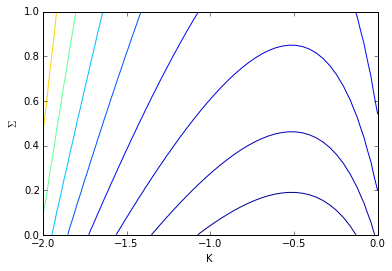

In [7]:
plotContours()

## The Optimal Solution

Before computing the policy gradient, it is helpful to examine the optimal solution, which can be computed analytically.

First note, that $J(\theta)$ monotonically increases with $\Sigma$. Since we are restricting ourselves to $\Sigma\ge 0$, we see that the optimal solution must have $\Sigma=0$. Close examination of the formula for $P$ indicates that $J(\theta)$ is actually linear in $\Sigma$. We will see later that this causes problems for gradient descent.

Now for $\Sigma=0$, this becomes a classical discounted LQR problem, and the optimal solution is given by
\begin{equation*}
K = -\gamma(R+\gamma B'SB)^{-1}B'SA,
\end{equation*}
where $S$ satisfies the Riccati equation 
\begin{equation*}
S = Q + \gamma A'SA - \gamma^2 A'SB(R+\gamma B'SB)^{-1} B'SA.
\end{equation*}

In [8]:
Sopt = la.solve_discrete_are(np.sqrt(gamma)*A,np.sqrt(gamma)*B,Q,R)

Omega = R + gamma * np.dot(B.T,np.dot(Sopt,B))
RightMat = -gamma * np.dot(B.T,np.dot(Sopt,A))
Kopt = la.solve(Omega,RightMat,sym_pos=True)

print 'Kopt: %g' % Kopt

n = len(A)
thetaOpt = np.zeros(n+1)
thetaOpt[:-1] = Kopt[0]
Jopt = policyValue(thetaOpt)

print 'Jopt: %g' % Jopt

Kopt: -0.514618
Jopt: 0.908771


In [9]:
# Now we'll add the optimum to the plot.
def plotContoursOpt():
    plotContours()
    plt.plot(Kopt[0],[0],'r*',linewidth=20)

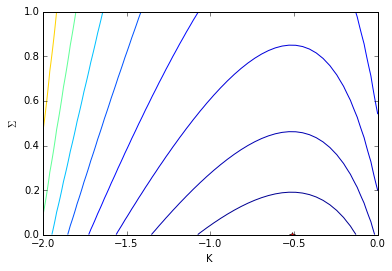

In [10]:
plotContoursOpt()

## The policy Gradient Formula

Returning to the policy gradient problem. 
With the formula for $J(\theta)$ established, it can be shown that the gradient is given by 
\begin{equation*}
\nabla_{\theta}J(\theta) = 
\begin{bmatrix}
2P(K'R + \gamma(A+BK)'SB) \\
R + \gamma B'SB
\end{bmatrix},
\end{equation*}
where $S$ is the solution to the following Lyapunov equation:
\begin{equation*}
\gamma(A+BK)'S(A+BK)+Q+K'RK=S
\end{equation*}
As with $P$, $S$ is unique and positive definite whenever $\sqrt{\gamma} (A+BK)$ is a stable matrix.

Examining the gradient formula reveals a problem with the standard policy gradient. In particular, we see that 
\begin{equation*}
\frac{\partial J(\theta)}{\partial \Sigma} = R + \gamma B'SB > R>0,
\end{equation*}
since $S\succ 0$.

So, we see that the gradient is above a constant value, and so a standard gradient descent algorithm would have the problem that $\Sigma$ would become negative. 

The reason for this issue is that $J(\theta)$ depends on $\Sigma$ linearly. So, it has no minimum with respect to $\Sigma$, unless you put the extra contraint that $\Sigma\ge 0$.



In [11]:
def discountedBellman(theta):
    K = theta[:-1].T
    Sigma = theta[-1]
    
    M = Q + np.dot(K.T,np.dot(R,K))
    Acl = np.sqrt(gamma)*(A+np.dot(B,K))
    S = la.solve_discrete_lyapunov(Acl,M)
    
    return S

In [12]:
def policyGradient(theta):
    K = theta[:-1].T
    Sigma = theta[-1]
    
    Grad = np.zeros(len(theta))
    
    # Top entries
    P = discountedCovariance(theta)
    S = discountedBellman(theta)
    Acl = np.sqrt(gamma)*(A+np.dot(B,K))
    RightVec = np.dot(K.T,R) + np.dot(Acl.T,np.dot(S,B))
    Grad[:-1] = 2*np.dot(P,RightVec)
    
    # Bottom Entry
    Grad[-1] = R + gamma * np.dot(B.T,np.dot(S,B))
    return Grad

In [13]:
Jgrad = policyGradient(theta)
print 'Policy Gradient:',Jgrad

Policy Gradient: [ 4.99771243  2.31884058]


# Dynamics of Standard Gradient Descent

Let's see concretely what would happen if we did a standard gradient descent (in continuous time):

\begin{equation*}
\frac{d\theta(t)}{dt} = - \nabla_{\theta}J(\theta(t)).
\end{equation*}

This can be visualized using a phase plane plot.

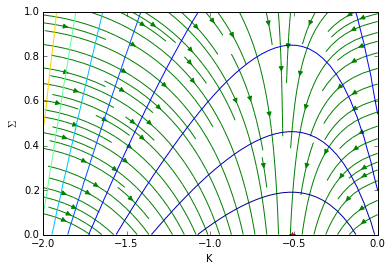

In [14]:
# Now let's look at the a phase plane
plotContoursOpt()

Kvel = np.zeros(Kgrid.shape)
Svel = np.zeros(Kgrid.shape)
for i in range(Kgrid.shape[0]):
    for j in range(Kgrid.shape[1]):
        thetaGrid = np.array([Kgrid[i,j],Sgrid[i,j]])
        gradGrid = policyGradient(thetaGrid)
        Kvel[i,j] = -gradGrid[0]
        Svel[i,j] = -gradGrid[1]
        
plt.streamplot(KgridLin,SgridLin,Kvel,Svel,color='g')

# Problems with standard gradient descent

From this plot, we can see that the noise will be driven to zero before we actually reach the optimal gain, $K$.

##  Natural Policy Gradients

Now we'll demonstrate a variation on gradient descent that corrects the problems. 

## Fisher Information Matrix.
First, we need to introduce the *Fisher information matrix*. The Fisher information matrix is a standard object in probability theory. If $p_{\theta}(x)$ is a probability density which is differentiable with respect to a parameter, $\theta$, then the Fisher information matrix is defined by

\begin{equation*}
G(\theta) = \mathbb{E}_{\theta}\left[
\left(\nabla_{\theta}\left(\log p_{\theta}(x)\right)
\right)
\left(
\nabla_{\theta}
\left(
\log p_{\theta}(x)
\right)
\right)'
\right]
\end{equation*}

As is well known, the Fisher information matrix is a Riemannian metric. I don't have a great intuition for Riemannian geometry, but Riemannian metrics show up all over the place. (The one I'm most familiar with is the inertia matrix from classical mechanics. . .)

## Specialization to Discounted Policy Evaluation

For the special case that $p_{\theta}$ is the distribution over trajectories induced by policy $\pi_{\theta}(u|x)$, the Fisher information matrix becomes:

\begin{equation*}
G(\theta) = (1-\gamma) \mathbb{E}_{\theta}\left[
\sum_{t=0}^{\infty} \gamma^t \left(\nabla_{\theta}\left(\log \pi_{\theta}(u_t|x_t)\right)\right)
\left(
\nabla_{\theta}
\left(
\log\pi_{\theta}(u_t|x_t)
\right)
\right)'
\right]
\end{equation*}

 The gradient with respect to the metric induced by $G(\theta)$ is thus given by:
\begin{equation*}
\tilde{\nabla}_{\theta} J(\theta) = G(\theta)^{-1} \nabla_{\theta}J(\theta).
\end{equation*}
This expression is known as the *natural policy gradient*.

It can be shown that in the linear-quadratic case, the Fisher information matrix is given by
\begin{equation*}
G(\theta) = \begin{bmatrix}
\frac{1}{\Sigma} P & 0 \\
0 & \frac{1}{2\Sigma^2}
\end{bmatrix}.
\end{equation*}

Thus, for linear-quadratic systems nautural policy gradient is given by:

\begin{equation*}
G(\theta)^{-1} \nabla_{\theta}J(\theta) = 2\Sigma \begin{bmatrix}
K'R + \gamma (A+BK)'SB \\
\Sigma(R+B'SB)
\end{bmatrix}.
\end{equation*}

There are a few important things to note from this expression:

* The natural gradient does not depend on $P$. Note that $P$ depends linearly on the initial second moment: $P_0+\mu_0\mu_0'$, but $S$ does not depend on the initial statistics, $\mu_0,P_0$.  It follows that the natural policy gradient is independent of the initial statistics.

* The natural gradient goes to $0$ as $\Sigma \to 0$. Thus, following the natural policy gradient will drive the noise to $0$, but not negative.

* The gradient with respect to $\Sigma$ goes to $0$ faster than the gradient with respect to $K$. Thus, when $\Sigma$ is small, the gain will change more quickly than $\Sigma$. This ensures convergence to the optimal gain as $\Sigma \to 0.$

In [15]:
def fisherInformation(theta):
    Sigma = theta[-1]
    P = discountedCovariance(theta)
    G = la.block_diag(P/Sigma,1./(2*Sigma**2.))
    return G

In [16]:
def naturalPolicyGradient(theta):
    """
    Natural policy gradient
    
    Becomes ill defined if Sigma = 0. This could be fixed, but it woud require a bit more code.
    """
    G = fisherInformation(theta)
    grad = policyGradient(theta)
    natGrad = la.solve(G,grad,sym_pos=True)
    return natGrad
    

In [17]:
JNatGrad = naturalPolicyGradient(np.array([-.1,.01]))
print 'Natural Policy Gradient:', JNatGrad

Natural Policy Gradient: [ 0.03312813  0.00052656]


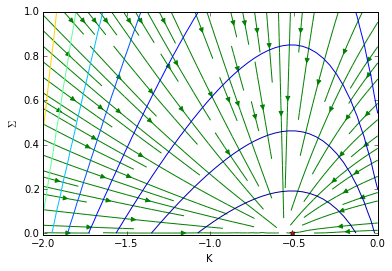

In [18]:
plotContoursOpt()

for i in range(Kgrid.shape[0]):
    for j in range(Kgrid.shape[1]):
        thetaGrid = np.array([Kgrid[i,j],Sgrid[i,j]])
        gradGrid = naturalPolicyGradient(thetaGrid)
        Kvel[i,j] = -gradGrid[0]
        Svel[i,j] = -gradGrid[1]
        
plt.streamplot(KgridLin,SgridLin,Kvel,Svel,color='g')

# Estimating Natural Gradients from Simulation Data

Now we will see how to estimate the natural gradients from simulation data. The code above all relied on standard Scipy stack tools. The code below, however, requires tools from the SimInterface package. (Thus, it will not run on external websites or in other folders.)

## Some formulas

\begin{equation*}
\nabla_{\theta}\log\pi_{\theta}(u|x) = 
\frac{1}{\Sigma}
\begin{bmatrix}
x(u-Kx) \\
\frac{1}{2\Sigma}(u-Kx)^2 - \frac{1}{2}
\end{bmatrix}
\end{equation*}

\begin{equation*}
V_{\theta}(x) = \mathbb{E}_{\theta}\left[
\sum_{t=0}^{\infty}
\gamma^t c(x_t,u_t)
| x_0 = x
\right]
\end{equation*}

In the linear quadratic case:

\begin{equation*}
V_{\theta}(x) = \mathbb{E}_{\theta}\left[
\sum_{t=0}^{\infty}
\gamma^t \left(x_t' Q x_t + u_t'Ru_t \right)
| x_0 = x
\right]
\end{equation*}

Bellman equation:
\begin{equation*}
V_{\theta}(x) = \mathbb{E}_{\theta}\left[
x_0' Q x_0 + u_0' R u_0 + V_{\theta}(x_1)
| x_0 = x
\right]
\end{equation*}

In this case, the Bellman equation can be solved to find that 
\begin{equation*}
V_{\theta}(x) = x'Sx + c,
\end{equation*}
where $S$ was computed from the Lyapunov equation above and the constant is given by
\begin{equation*}
c = \frac{1}{1-\gamma}\mathrm{Tr}\left((R+\gamma B'SB)\Sigma\right).
\end{equation*}
Since the system has a single input, we don't really need the trace, but it is good to know that the formula generalizes to the case that $\Sigma$ is a matrix.

From this
\begin{equation*}
Q_{\theta}(x,u) = 
\mathbb{E}_{\theta}\left[
\sum_{t=0}^{\infty}
\gamma^t \left(x_t' Q x_t + u_t'Ru_t \right)
| x_0 = x, u_0=u
\right]
\end{equation*}
is computed to be
\begin{equation*}
Q_{\theta}(x,u) = 
\begin{bmatrix}
x \\
u
\end{bmatrix}'
\begin{bmatrix}
Q + \gamma A'SA & \gamma A'SB \\
\gamma B'SA & R + \gamma B'SB
\end{bmatrix}
\begin{bmatrix}
x \\
u
\end{bmatrix}
+
\gamma c
\end{equation*}

The *advantage function* is then given by
\begin{equation*}
A_{\theta}(x,u) := Q_{\theta}(x,u) - V_{\theta}(x) = 
\begin{bmatrix}
x \\
u
\end{bmatrix}'
\begin{bmatrix}
Q + \gamma A'SA - S & \gamma A'SB \\
\gamma B'SA & R + \gamma B'SB
\end{bmatrix}
\begin{bmatrix}
x \\ 
u\
\end{bmatrix} 
- \mathrm{Tr}\left((R+\gamma B'SB)\Sigma\right)
\end{equation*}

By construction, both $\nabla_{\theta}\log\pi_{\theta}(u|x)$ and $A_{\theta}(x,u)$ satisfy
\begin{align*}
\mathbb{E}_{\theta}\left[
\nabla_{\theta}\log\pi_{\theta}(u|x)
| x
\right] &= 0  \\
\mathbb{E}_{\theta}\left[
A_{\theta}(x,u)
| x
\right] &= 0.
\end{align*}

Thus, for any coefficients $w$, the following relationship holds:
\begin{equation*}
A_{\theta}(x,u) = \nabla_{\theta}\log\pi_{\theta}(u|x)'w + \textrm{ zero mean random variable. }
\end{equation*}

Similarly, 
\begin{equation*}
\mathbb{E}_{\theta}\left[V_{\theta}(x_{t+1}) | x_t \right] = V_{\theta}(x_{t+1}) + 
\left(
\mathbb{E}_{\theta}\left[V_{\theta}(x_{t+1}) | x_t \right] - V_{\theta}(x_{t+1}),
\right)
\end{equation*}
where the second term on the right has zero mean. Thus, it follows that the Bellman equation can be rearranged to give 
\begin{equation*}
\nabla_{\theta}\log\pi_{\theta}(u_t|x_t)'w + 
V_{\theta}(x_t) = \gamma V_{\theta}(x_{t+1}) + \textrm{ zero mean random variable. }
\end{equation*}

In [19]:
import SimInterface.functionApproximatorctionApproximator as fa